# 🌞**Évaluation et Prévision des Énergies Renouvelables Variables (ERV)**

## 🎯 **Objectifs du Projet**

1. **Évaluer la production horaire des installations photovoltaïques** dans les régions de la France métropolitaine en utilisant des données climatiques et des observations des facteurs de capacité.

2. **Prédire la production énergétique des ERV à l'avance**, afin de mieux anticiper les variations de puissance et optimiser la gestion du réseau électrique.




---

## Lire les donnéees

Récupérer les données de production solaire 

In [18]:
#!pip install requests
#!pip install xarray netcdf4
#!pip install matplotlib

In [8]:
import requests
import pandas as pd
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# URL de l'API
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/parc-regional-annuel-prod-eolien-solaire/records?select=annee%2Cregion%2Cparc_installe_solaire&where=annee%3E2013%20AND%20annee%3C2021&limit=100"

# Configurer le retry pour gérer les échecs temporaires
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('https://', HTTPAdapter(max_retries=retries))

try:
    # Effectuer une requête GET
    response = session.get(url, timeout=30)
    response.raise_for_status()  # Vérifie si la requête a réussi

    # Charger les données JSON
    data = response.json()
    results = data.get("results", [])

    # Extraire les champs pertinents
    formatted_data = [
        {
            "annee": record.get("annee"),
            "region": record.get("region"),
            "parc_installe_solaire": record.get("parc_installe_solaire")
        }
        for record in results
    ]

    # Créer un DataFrame pandas
    df = pd.DataFrame(formatted_data)

    # Réorganiser le tableau pour qu'il soit structuré par année et région
    df_pivot = df.pivot(index="annee", columns="region", values="parc_installe_solaire").reset_index()
    df_pivot.columns.name = None  # Supprimer le nom des colonnes multi-index

    # Exporter les données au format CSV
    output_path = "parc_installe_solaire_2014_2019.csv"
    df_pivot.to_csv(output_path, index=False)

    print(f"Données exportées avec succès : {output_path}")

except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête API : {e}")
except Exception as e:
    print(f"Erreur générale : {e}")


Données exportées avec succès : parc_installe_solaire_2014_2019.csv


In [9]:
import pandas as pd

# Charger les deux fichiers existants
production_solaire_df = pd.read_csv("production_solaire_2014_2019.csv")
parc_installe_solaire_df = pd.read_csv("parc_installe_solaire_2014_2019.csv")

# Assurez-vous que les deux fichiers sont alignés sur les mêmes colonnes et années
production_solaire_df['annee'] = pd.to_datetime(production_solaire_df['mois']).dt.year
parc_installe_solaire_df = parc_installe_solaire_df.set_index("annee")

# Diviser les valeurs de production solaire par le parc installé correspondant
for region in production_solaire_df.columns[1:-1]:  # Ignorer 'mois' et 'annee'
    if region in parc_installe_solaire_df.columns:
        production_solaire_df[region] = production_solaire_df.apply(
            lambda row: row[region] / parc_installe_solaire_df.loc[row['annee'], region]
            if not pd.isna(row[region]) and not pd.isna(parc_installe_solaire_df.loc[row['annee'], region]) else None,
            axis=1
        )

# Multiplier toutes les valeurs par 1000 (conversion de GWh à MWh)
# Diviser ensuite par 24 * 30.5 (heures dans un mois)
conversion_factor = 1000 / (24 * 30.5)
production_solaire_df.iloc[:, 1:] = production_solaire_df.iloc[:, 1:] * conversion_factor

# Supprimer la colonne 'annee' (elle était temporaire)
production_solaire_df = production_solaire_df.drop(columns=['annee'])

# Exporter le nouveau fichier CSV
output_path = "normalized_production_solaire_2014_2019.csv"
production_solaire_df.to_csv(output_path, index=False)

print(f"Données normalisées et converties exportées avec succès : {output_path}")


Données normalisées et converties exportées avec succès : normalized_production_solaire_2014_2019.csv


/tmp/ipykernel_1061/1280283660.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     2751.366120
1     2751.366120
2     2751.366120
3     2751.366120
4     2751.366120
         ...     
67    2758.196721
68    2758.196721
69    2758.196721
70    2758.196721
71    2758.196721
Name: annee, Length: 72, dtype: float64' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  production_solaire_df.iloc[:, 1:] = production_solaire_df.iloc[:, 1:] * conversion_factor


<Axes: xlabel='mois'>

<Figure size 640x480 with 0 Axes>

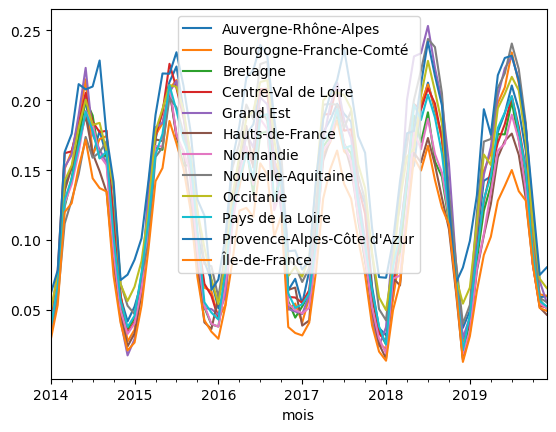

In [10]:
import matplotlib.pyplot as plt

filepath2='normalized_production_solaire_2014_2019.csv'
df_energy2 = pd.read_csv(filepath2, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy2.plot()

Récupérer les données climatiques 

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

data_dir_climate = "data"
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'



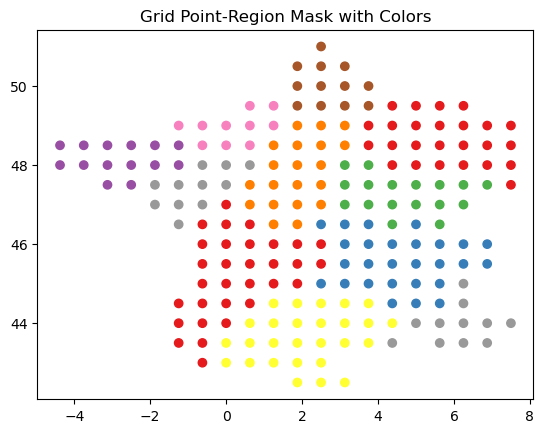

In [33]:

filename_mask = "mask_datagouv_french_regions_merra2_Nx_France.nc"

filepath_mask = Path(data_dir_climate, filename_mask)
 # Read and plot grid point-region mask

ds_mask = xr.load_dataset(filepath_mask, engine='netcdf4')
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')
plt.title('Grid Point-Region Mask with Colors')
region_names = df_energy.columns.tolist()

Visualisation des données de production

<Figure size 640x480 with 0 Axes>

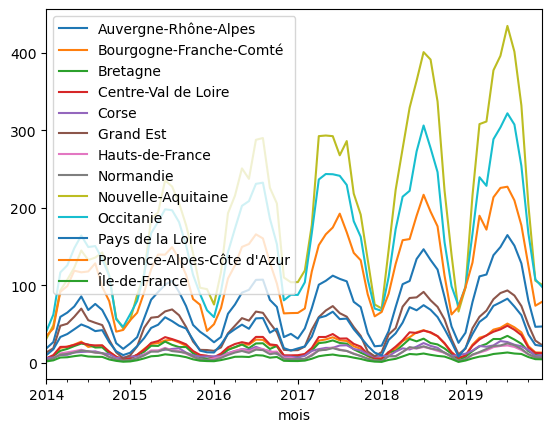

In [45]:
# Chemin vers le fichier CSV
filepath = "production_solaire_2014_2019.csv"
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()
df_energy = df_energy.rename(columns={'Provence-Alpes-Côte d\'Azur': 'PACA'})
df_energy = df_energy.rename(columns={'Île-de-France': 'Ile-de-France'})
df_energy = df_energy.rename(columns={'Pays de la Loire': 'Pays-de-la-Loire'})

Concaténation des données

In [38]:
 #combiner toutes les datas du dossier climat
import os
# Liste des noms de variables (ou parties variables du nom de fichier)
variable_names = ['height_500','meridional_wind', 'surface_density','surface_downward_radiation','surface_specific_humidity','surface_temperature','upper_meridional_wind','upper_zonal_wind','zonal_wind']

processed_datasets = []

for variable_name in variable_names:
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir_climate, filename)

    if os.path.exists(filepath):  # Vérifiez si le fichier existe
        da_climate = xr.load_dataset(filepath)

        # Calculez la moyenne régionale
        da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
        da_climate_reg['region'] = ds_mask['region'].values

        # Ajoutez le résultat à la liste des ensembles de données traitées
        processed_datasets.append(da_climate_reg)
    else:
        print(f"Le fichier pour {variable_name} n'existe pas : {filepath}")

# Fusionnez tous les ensembles de données traités
combined_data = xr.merge(processed_datasets)
pre_climate = combined_data.to_dataframe()

Etude d'une région, normalisation des données, saisonalité

In [50]:
import math

#création de trois dictionnaires qui contiendront les données pour chaque région 
combined_dataframes = {}
energy_data = {}
climate_data={}

for region in region_names:


    # Filtrer 'pre_climate' pour obtenir les données de 'REGION_NAME' uniquement.
    cnd = pre_climate.index.get_level_values("region") == region
    climate_proj = pre_climate[cnd]
    climate_proj.index = climate_proj.index.droplevel("region")

    # Sélectionner les données énergétiques pour la même région.
    energy= df_energy[region]


    # Création d'un nouveau DataFrame 'climate' avec les mêmes indices que 'energy' 
    # et les mêmes colonnes que 'climate_proj', initialisé avec des valeurs NaN.
    climate = pd.DataFrame(index=energy.index, columns=climate_proj.columns, dtype=np.float64)
print(climate.columns)

Index(['height_500', 'meridional_wind', 'surface_density',
       'surface_downward_radiation', 'surface_specific_humidity',
       'surface_temperature', 'upper_meridional_wind', 'upper_zonal_wind',
       'zonal_wind'],
      dtype='object')


/opt/conda/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


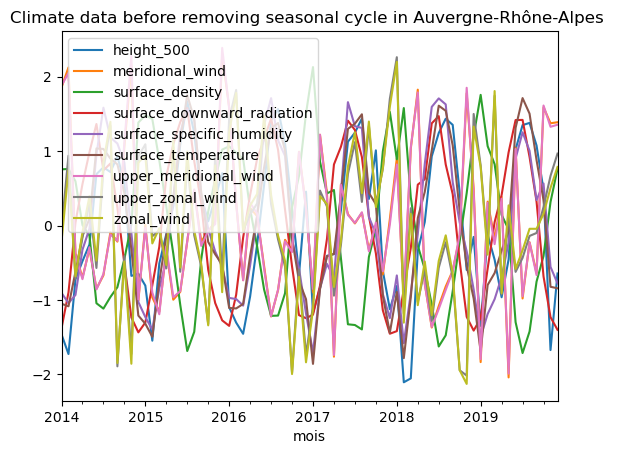

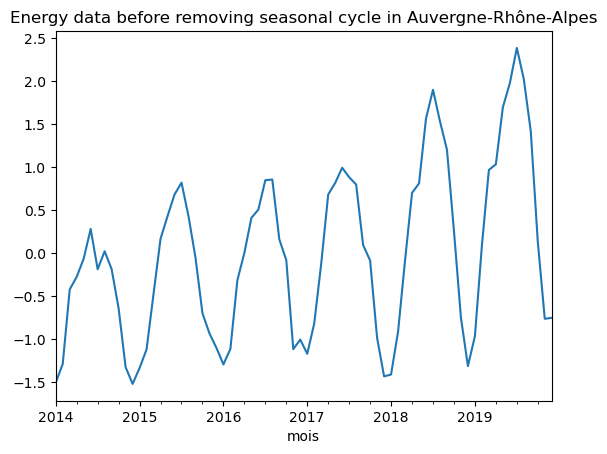

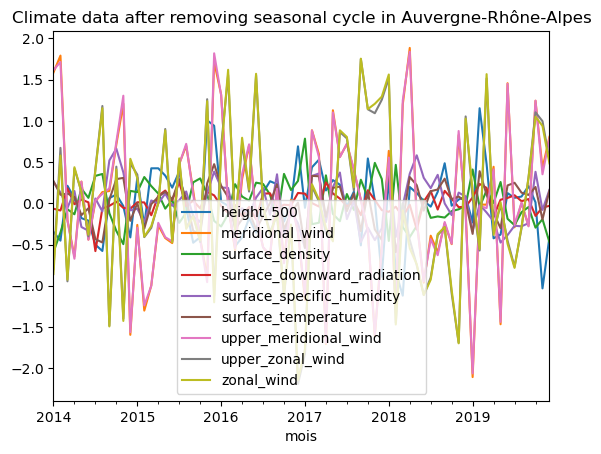

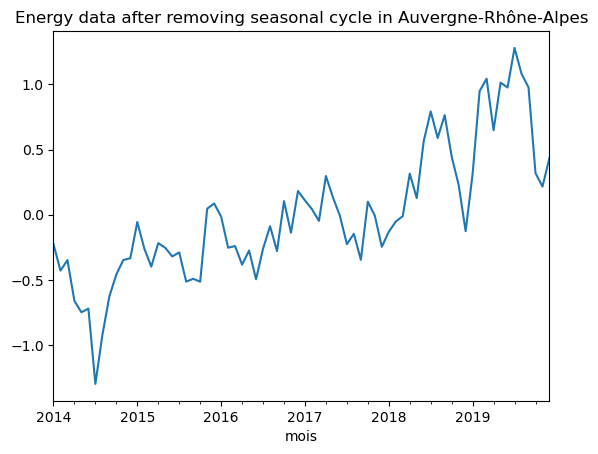

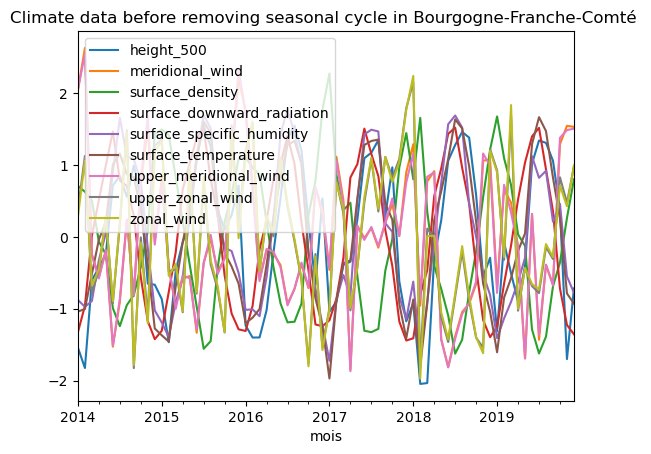

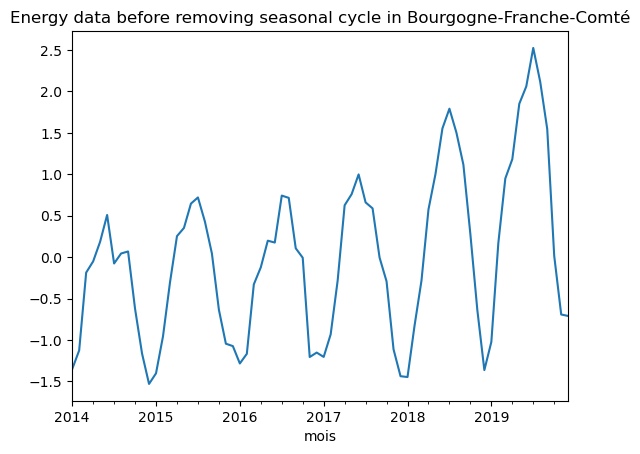

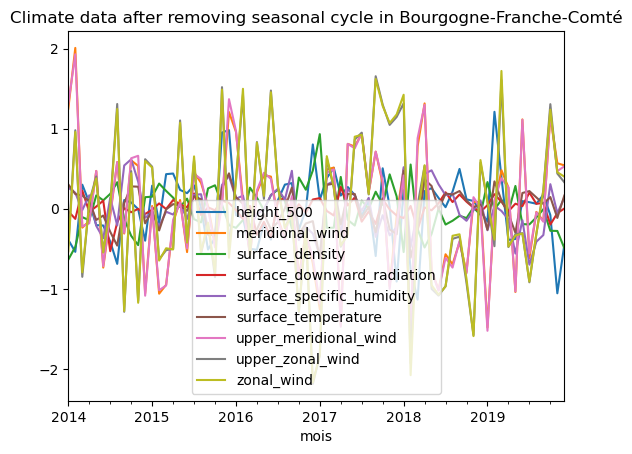

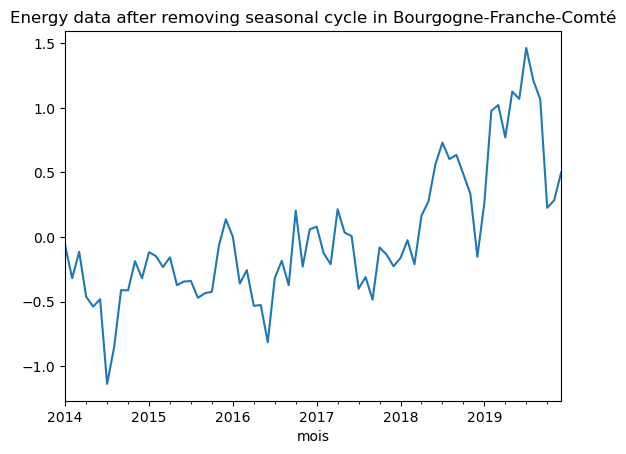

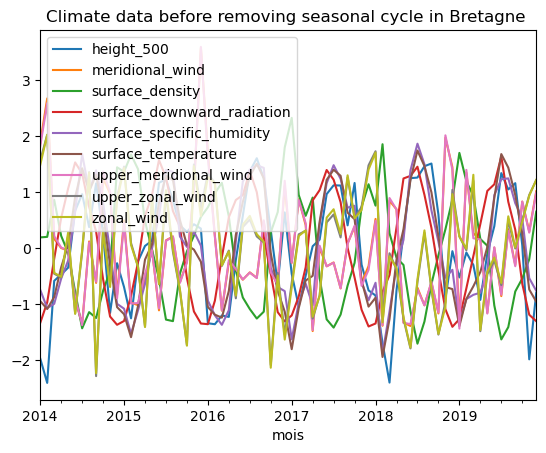

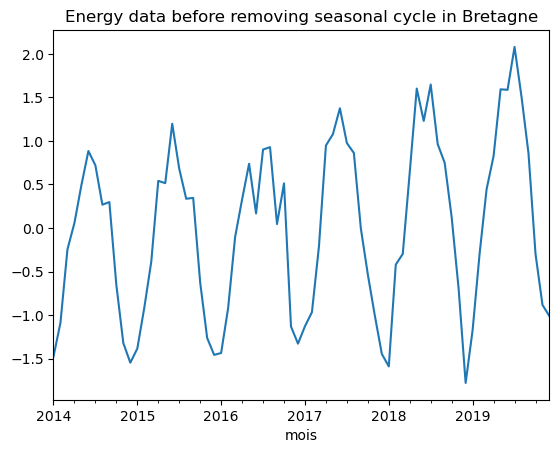

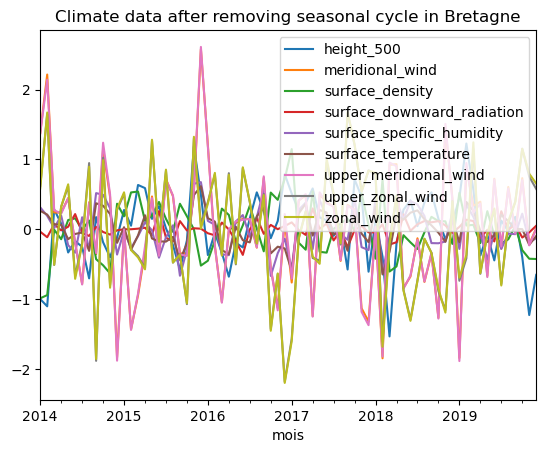

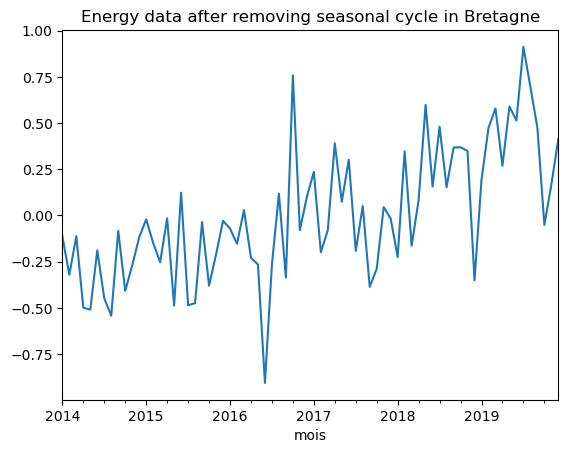

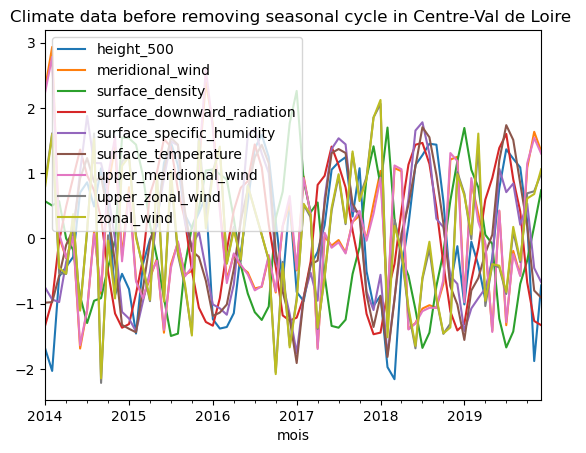

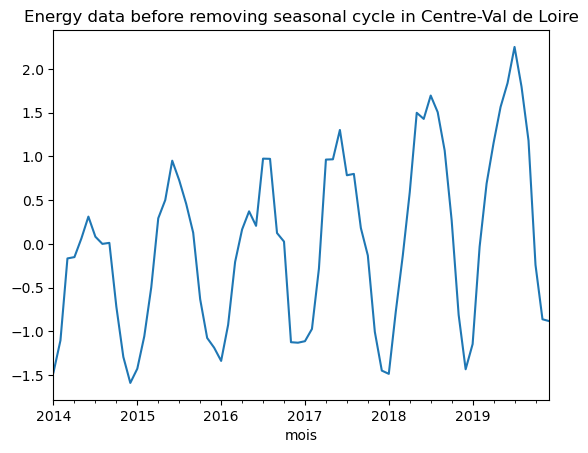

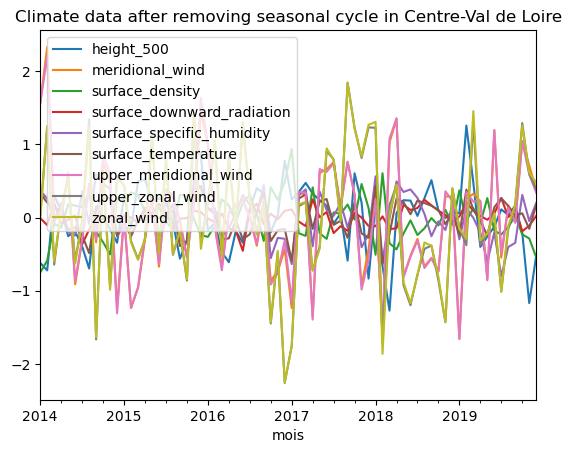

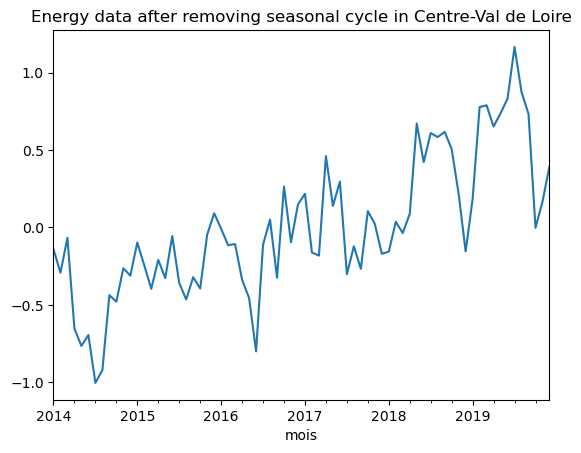

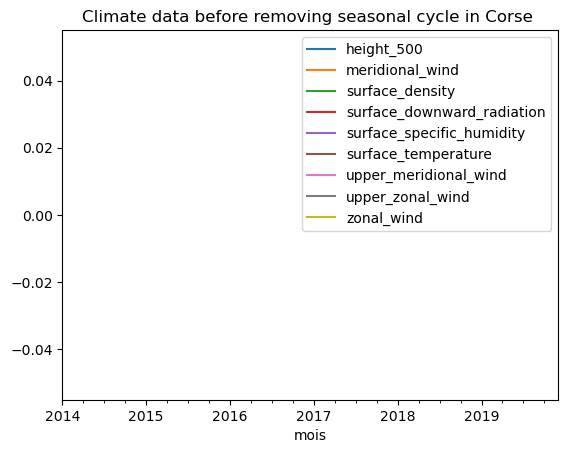

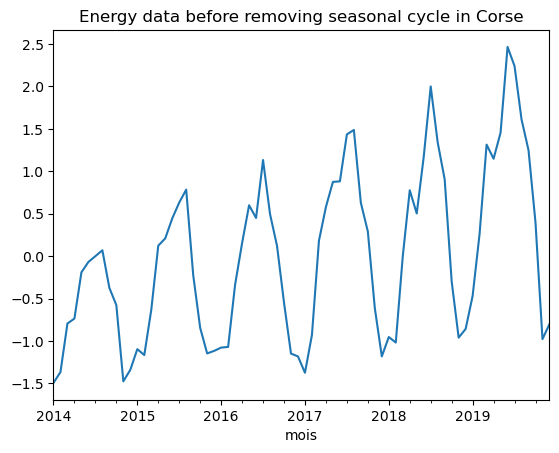

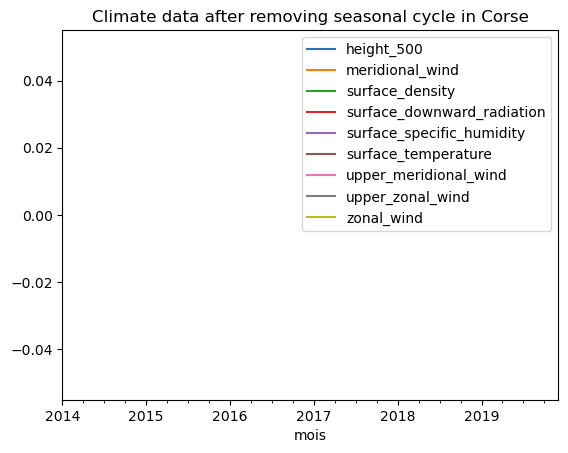

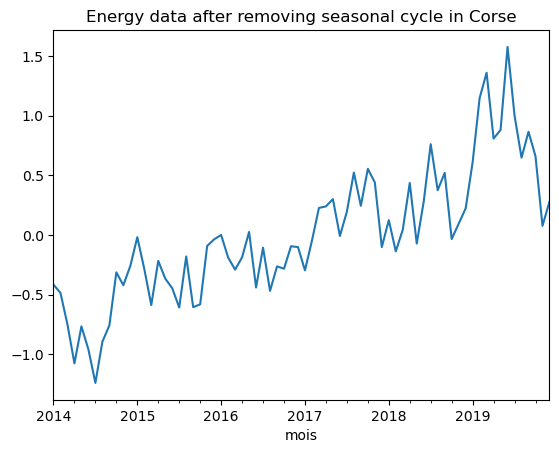

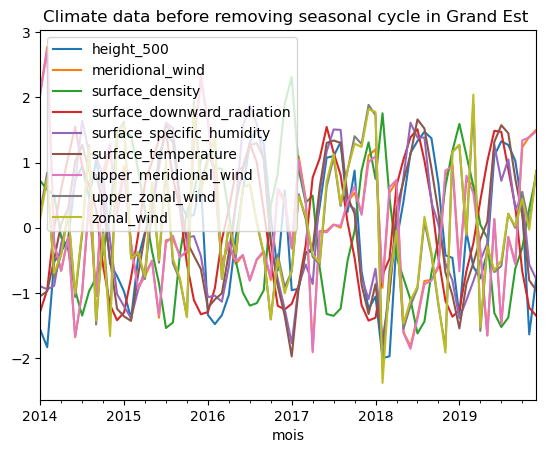

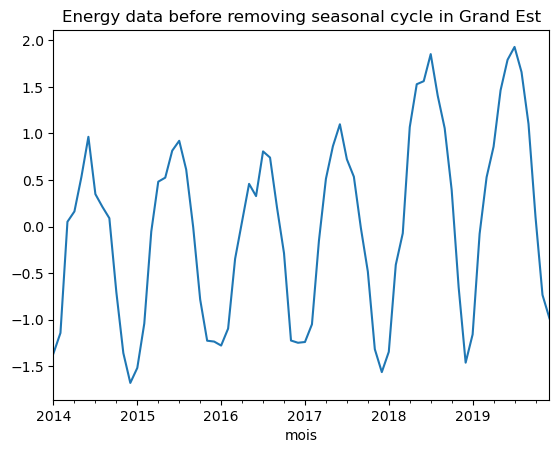

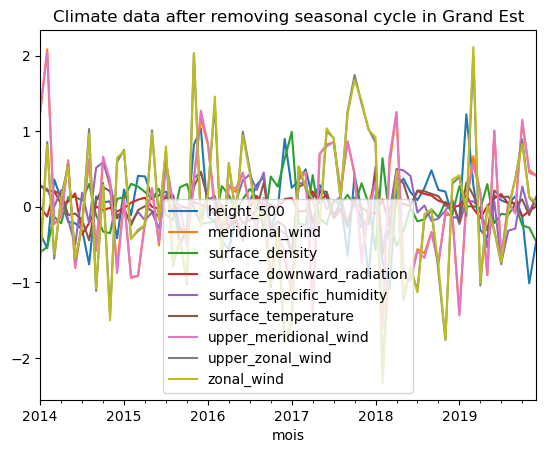

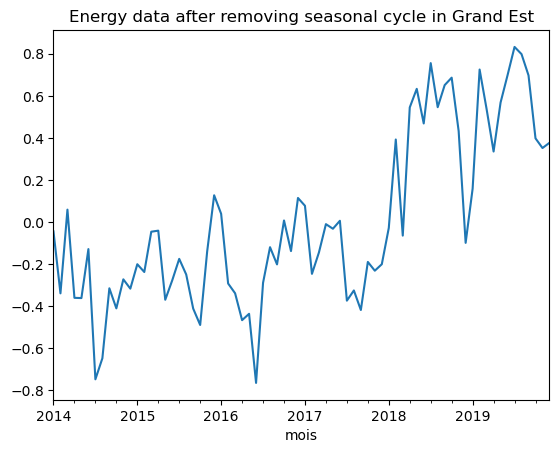

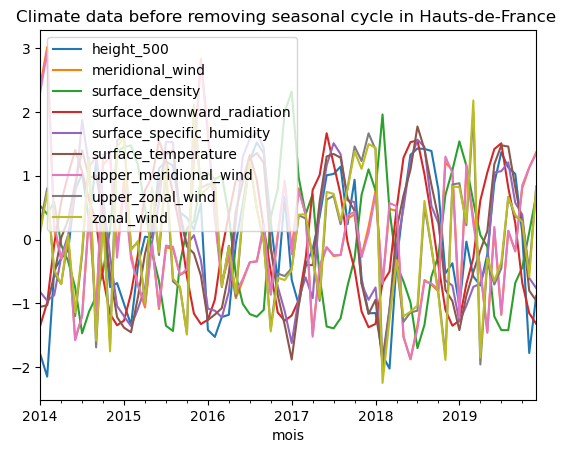

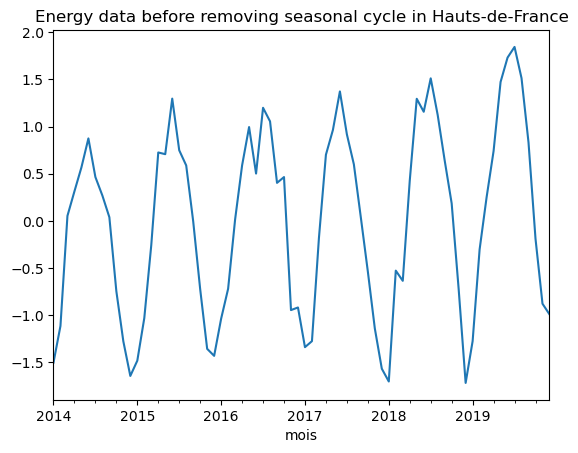

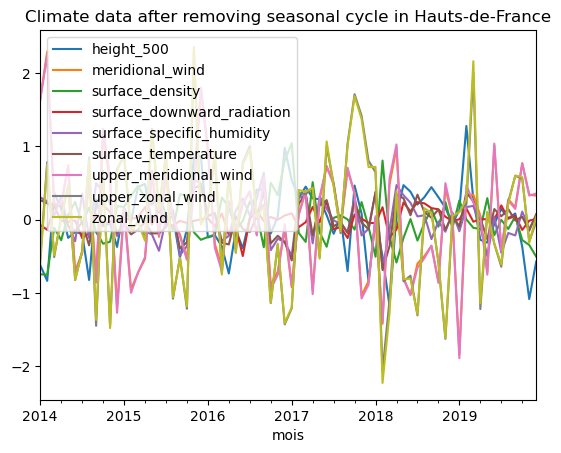

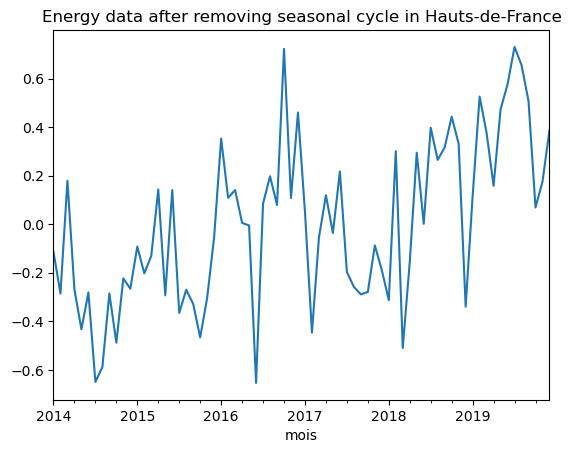

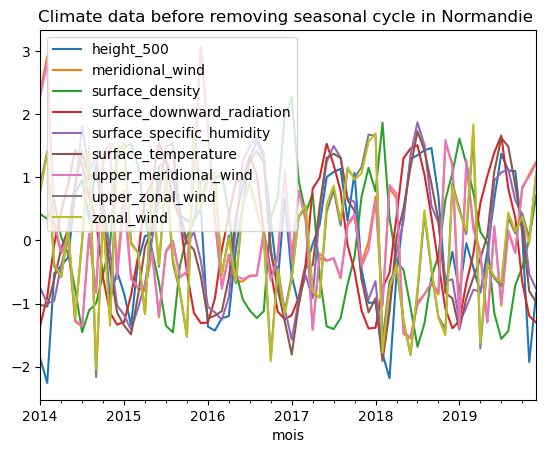

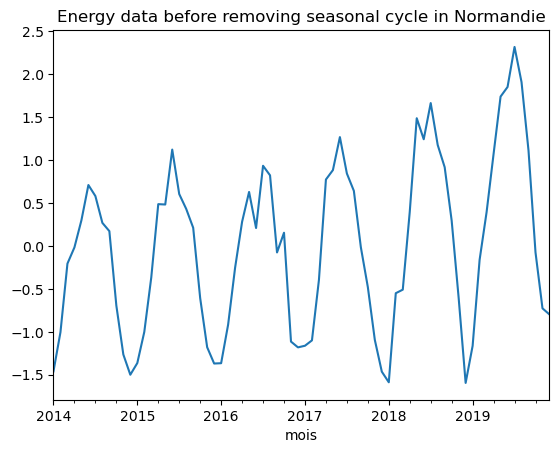

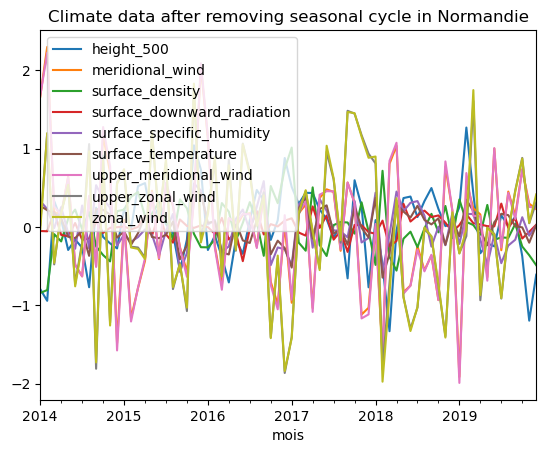

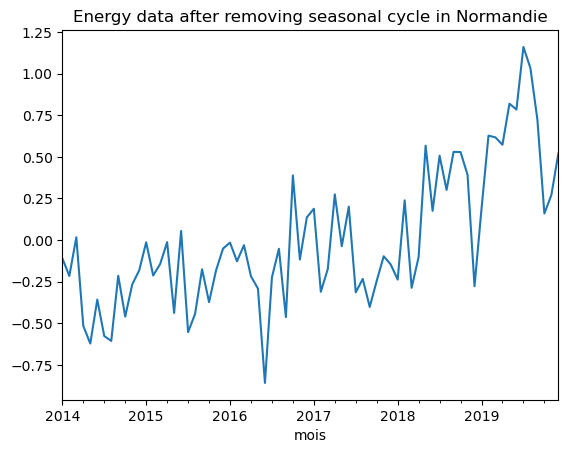

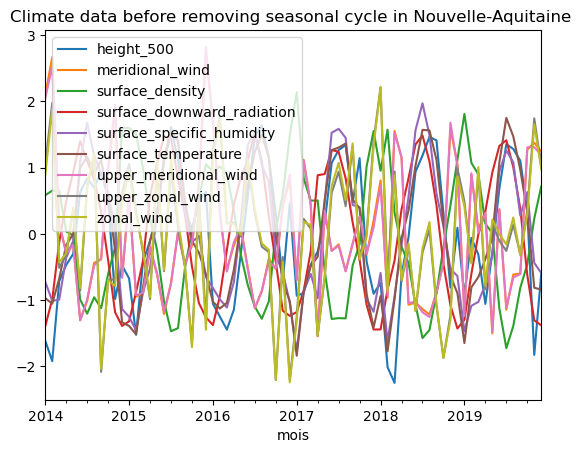

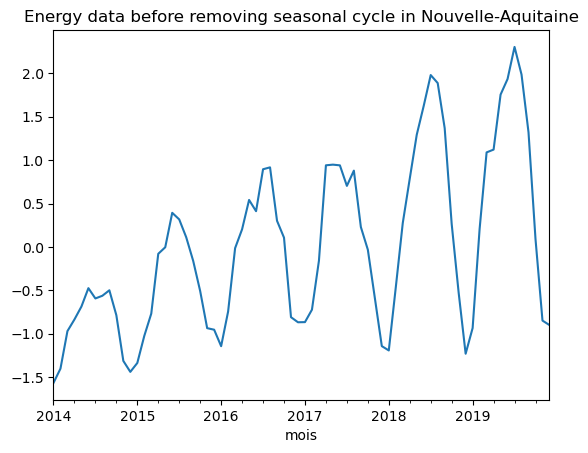

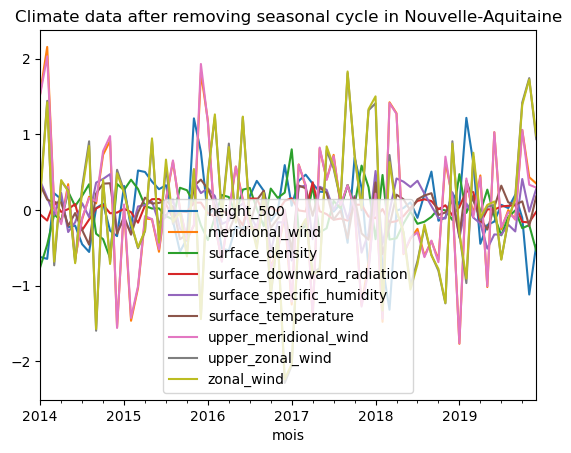

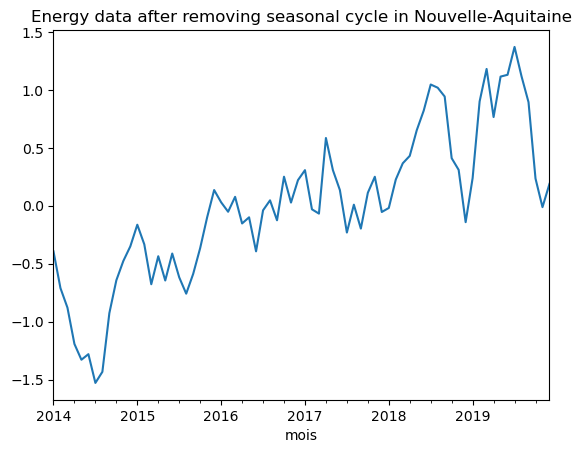

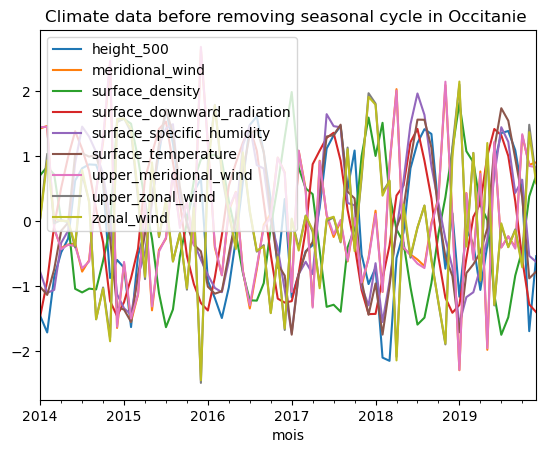

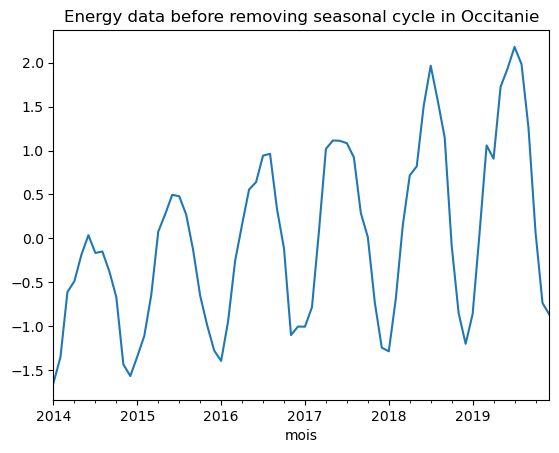

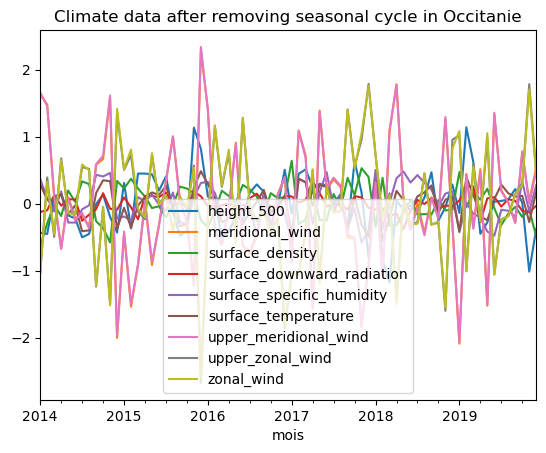

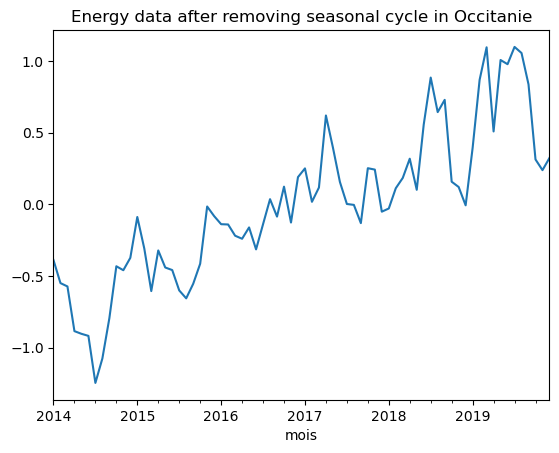

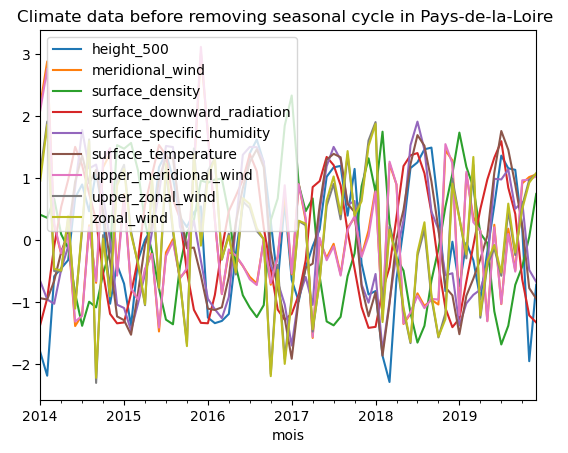

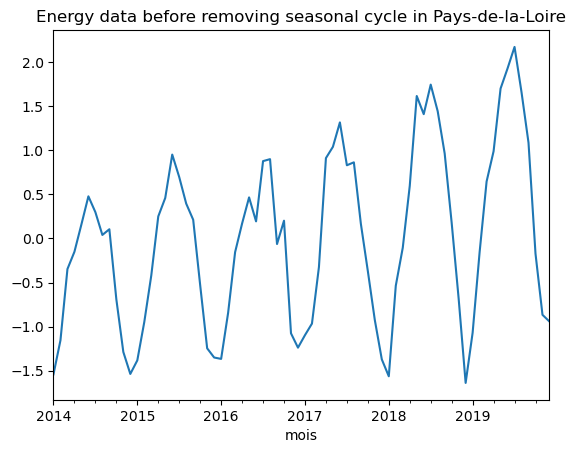

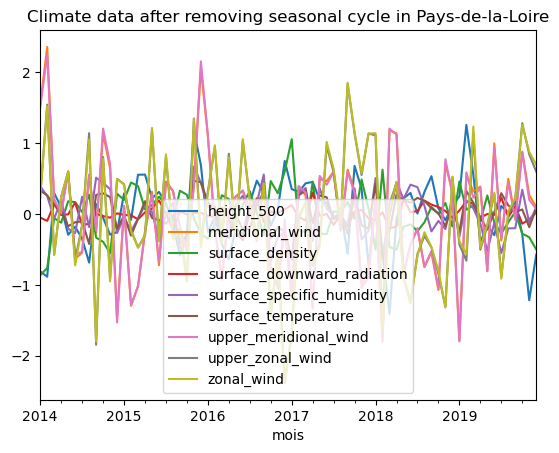

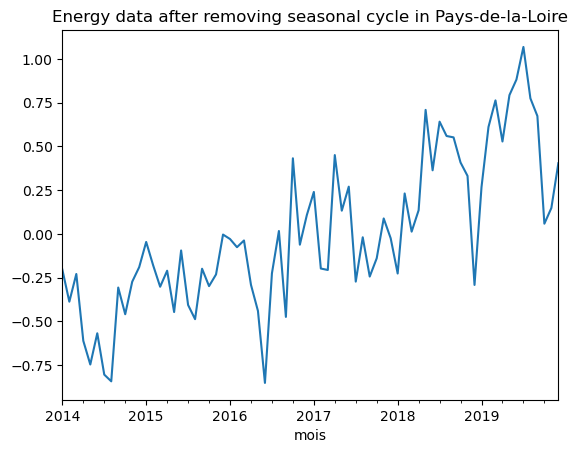

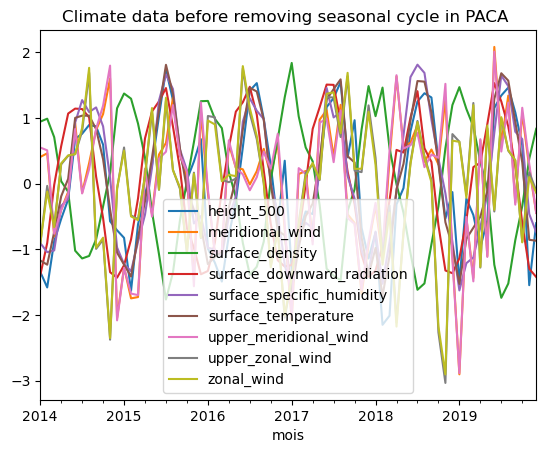

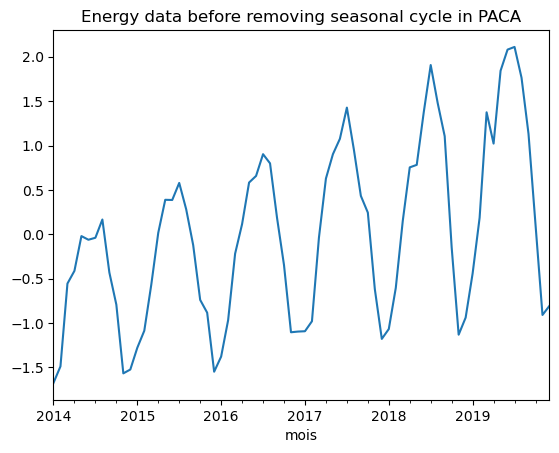

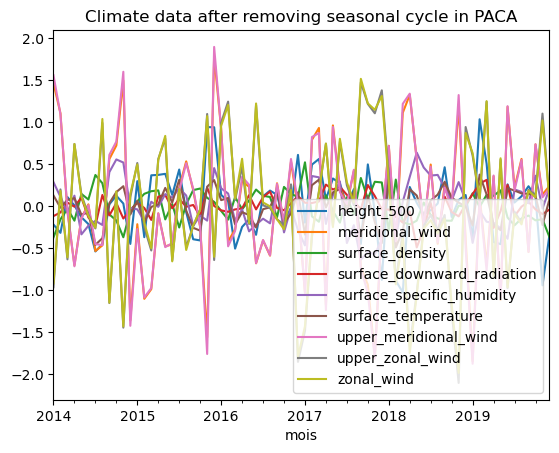

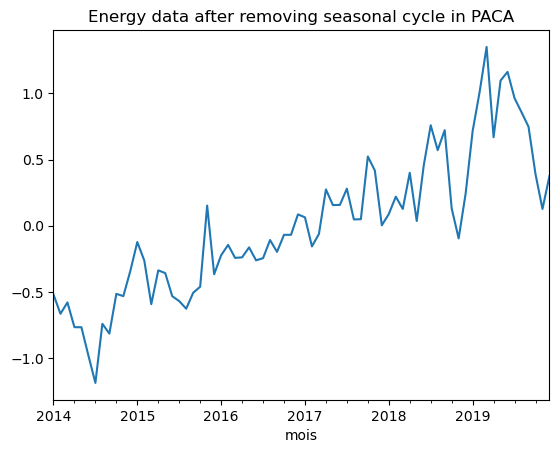

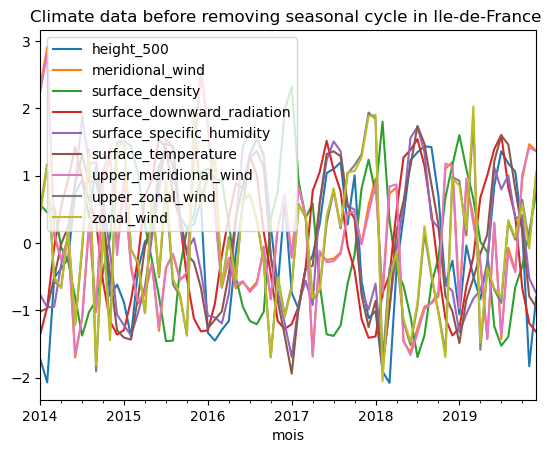

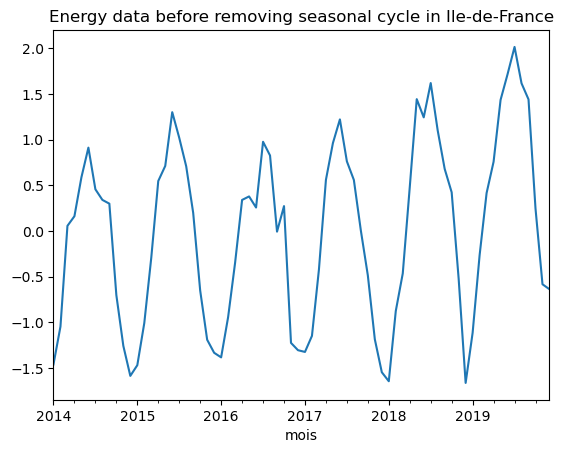

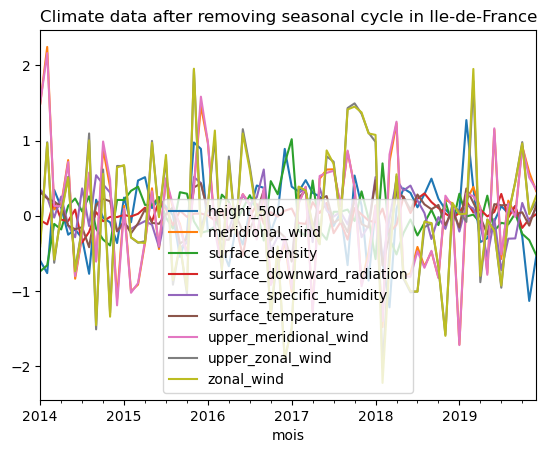

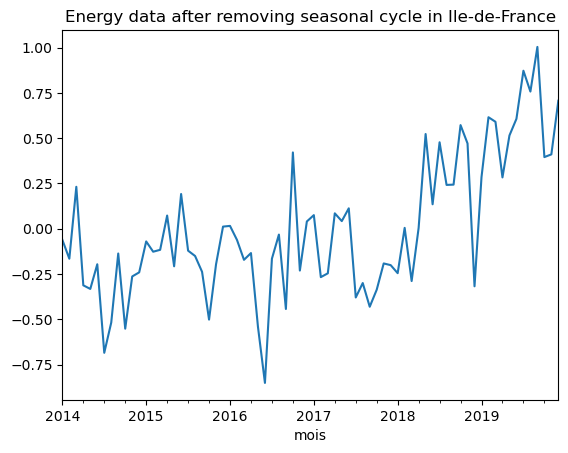

In [51]:
import math

#création de trois dictionnaires qui contiendront les données pour chaque région 
combined_dataframes = {}
energy_data = {}
climate_data={}

for region in region_names:


    # Filtrer 'pre_climate' pour obtenir les données de 'REGION_NAME' uniquement.
    cnd = pre_climate.index.get_level_values("region") == region
    climate_proj = pre_climate[cnd]
    climate_proj.index = climate_proj.index.droplevel("region")

    # Sélectionner les données énergétiques pour la même région.
    energy= df_energy[region]


    # Création d'un nouveau DataFrame 'climate' avec les mêmes indices que 'energy' (mois) 
    # et les mêmes colonnes que 'climate_proj', initialisé avec des valeurs NaN.
    climate = pd.DataFrame(index=energy.index, columns=climate_proj.columns, dtype=np.float64)

    # Calcul de la moyenne mensuelle des données climatiques pour chaque date dans 'climate'.
    for date in climate.index:
        climate.loc[date] = climate_proj[(climate_proj.index.get_level_values("time") >= date) & (climate_proj.index.get_level_values("time") < date + pd.Timedelta(days=30))].mean()

    # Normaliser les données climatiques et énergétiques. 
    climate = (climate - climate.mean()) / climate.std()
    energy = (energy - energy.mean()) / energy.std()
    climate.plot()
    plt.title(f'Climate data before removing seasonal cycle in {region} ')
    plt.figure()
    energy.plot()
    plt.title(f'Energy data before removing seasonal cycle in {region}')

    #enlever la saisonalité par région
    # Calcul des moyennes mensuelles pour chaque mois pour les données climatiques et énergétiques.
    avgs_climate = {}
    avgs_energy = {}
    for month in range(1, 13):
        avgs_climate[month] = climate[climate.index.get_level_values("mois").month == month].mean()
        avgs_energy[month] = energy[energy.index.get_level_values("mois").month == month].mean()
    
    # Soustraction des moyennes mensuelles des données originales pour chaque date.
    for date in energy.index:
        climate.loc[date] -= avgs_climate[date.month]
        energy.loc[date] -= avgs_energy[date.month]
    climate.plot()    
    plt.title(f'Climate data after removing seasonal cycle in {region}')
    plt.figure()
    energy.plot()
    plt.title(f'Energy data after removing seasonal cycle in {region}')
    #ajout en mémoire dans les dictionnaires
    energy_data[f"energy_{region}"] = energy
    climate_data[f"climate_{region}"] = climate
    
  # Concaténation des données climatiques et énergétiques en un seul DataFrame
    combined = pd.concat([climate, energy], axis=1)
    
    # Stockage du DataFrame dans le dictionnaire avec un nom clé dynamique
    combined_dataframes[f"combined_{region}"] = combined
    

